In [2]:
import clouddrift as cd

ds = cd.adapters.ibtracs.to_raggedarray("v04r01", "LAST_3_YEARS", "/home/ksantana/.clouddrift/tmp")
ds

https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/netcdf/IBTrACS.last3years.v04r01.nc: 100%|██████████| 1.45k/1.45k [00:00<00:00, 2.02MB/s]
Filling the Ragged Array: 100%|██████████████| 380/380 [00:02<00:00, 141.73it/s]


<xarray.Dataset> Size: 18MB
Dimensions:           (storm: 380, obs: 22055, quadrant: 4)
Coordinates:
    id                (storm) int64 3kB 0 1 2 3 4 5 ... 374 375 376 377 378 379
    time              (obs) datetime64[ns] 176kB 2021-01-01T00:00:00.00003993...
Dimensions without coordinates: storm, obs, quadrant
Data variables: (12/161)
    numobs            (storm) int64 3kB 27 45 129 71 35 43 ... 103 31 33 55 35
    sid               (storm) |S13 5kB b'2021001S14136' ... b'2024280N18146'
    season            (storm) float32 2kB 2.021e+03 2.021e+03 ... 2.024e+03
    number            (storm) int16 760B 1 2 3 4 5 6 7 ... 66 67 68 69 70 71 72
    name              (storm) |S128 49kB b'IMOGEN' b'UNNAMED' ... b'BARIJAT'
    source_usa        (storm) |S128 49kB b'bsh092021.dat' ... b'BOTH_tcvitals...
    ...                ...
    usa_seahgt        (obs) float32 88kB nan nan nan nan nan ... nan nan nan nan
    usa_searad        (obs, quadrant) float32 353kB nan nan nan ... nan nan nan
    storm_speed       (obs) float32 88kB 4.0 4.0 6.0 6.0 ... 23.0 23.0 21.0 21.0
    storm_dir         (obs) float32 88kB 140.0 145.0 155.0 ... 20.0 35.0 40.0
    lat               (obs) float32 88kB -13.8 -13.9 -14.1 ... 34.8 35.7 36.5
    lon               (obs) float32 88kB 136.4 136.5 136.7 ... 150.9 151.6 152.4
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r01
    ...                         ...
    history:                    Thu Oct 17 05:37:12 2024: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 5.0.7 (Homepage = ht...

In [3]:
import numpy as np

# Select the data for the year 2022 only by using the ragged.subset method
year = 2023
ds = cd.ragged.subset(
    ds,
    {"time": (np.datetime64(f"{year}-01-01"), np.datetime64(f"{year}-12-31"))},
    row_dim_name="storm",
    rowsize_var_name="numobs"
)
ds

<xarray.Dataset> Size: 5MB
Dimensions:           (storm: 92, obs: 5968, quadrant: 4)
Coordinates:
    id                (storm) int64 736B 213 215 218 219 220 ... 304 305 306 307
    time              (obs) datetime64[ns] 48kB 2023-01-01T00:00:00.000039936...
Dimensions without coordinates: storm, obs, quadrant
Data variables: (12/161)
    numobs            (storm) int64 736B 1 59 45 28 35 101 ... 11 49 49 118 35
    sid               (storm) |S13 1kB b'2022346S10098' ... b'2023349N04141'
    season            (storm) float32 368B 2.023e+03 2.023e+03 ... 2.023e+03
    number            (storm) int16 184B 108 110 1 2 3 4 5 ... 85 86 87 88 89 90
    name              (storm) |S128 12kB b'DARIAN' b'ELLIE' ... b'JELAWAT'
    source_usa        (storm) |S128 12kB b'BOTH_tcvitals.txt:Line=3894' ... b...
    ...                ...
    usa_seahgt        (obs) float32 24kB nan nan nan nan nan ... nan nan nan nan
    usa_searad        (obs, quadrant) float32 95kB nan nan nan ... nan nan nan
    storm_speed       (obs) float32 24kB 14.0 3.0 3.0 4.0 ... 2.0 4.0 8.0 12.0
    storm_dir         (obs) float32 24kB 130.0 345.0 35.0 ... 285.0 300.0 295.0
    lat               (obs) float32 24kB -34.5 -17.5 -17.3 -17.2 ... 7.3 7.4 7.7
    lon               (obs) float32 24kB 70.6 127.0 127.0 ... 125.8 125.7 125.1
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r01
    ...                         ...
    history:                    Thu Oct 17 05:37:12 2024: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 5.0.7 (Homepage = ht...

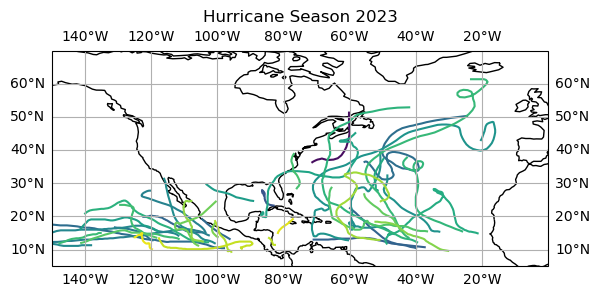

In [4]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# make figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
hl = cd.plotting.plot_ragged(
    ax,
    ds.lon,
    ds.lat,
    ds.numobs,
    transform=ccrs.PlateCarree(),
)
ax.set_extent([-150, 0, 5, 70], crs=ccrs.PlateCarree())
ax.set_title(f"Hurricane Season {year}")
ax.coastlines()
ax.gridlines(draw_labels=True)